### Apuntes y Ejercicios Clase 22 IIQ2023

Operaciones Unitarias 2

Autor: Prof. Felipe Huerta

Separaciones por membranas 2, v2

v1: 27/05/2023
v2: 02/06/2025

In [2]:
# Calculos manuales
import handcalcs.render
from handcalcs import handcalc

# Unidades consistentes
import forallpeople as si

# Computación científica
import numpy as np
import matplotlib.pyplot as plt

# Integración
from scipy import integrate

from scipy.optimize import fsolve


# Funciones matemáticas para mejorar presentación
from numpy import sqrt, pi, log

# Ajustes polinomiales
from numpy.polynomial import Polynomial

# Cálculos manuales
si.environment('thermal', top_level=True)

### Solución numérica paso a paso para un separador de gases con membranas operando a contracorrientes

Ilustraremos la metodología numérica para el mismo ejercicio estudiado en la Clase 21. Este ejercicio corresponde a la separación de la mezcla gaseosa hidrógeno-metano utilizando membranas.

* Se asumirá la entrada como una mezcla binaria con fracción molar de hidrógeno $x_A = 0.05$ y fracción molar de metano $x_B = 1-x_A = 0.95$.


#### Nomenclatura:

$y'$ es a fracción molar del gas de mayor permeabilidad que sale de la membrana hacia el lado del permeado.

y es la fracción molar del soluto en el seno del permeado (lumen de la fibra).

x es la fracción molar del soluto en el seno del retenido (región anular).

#### Paso 1: Comenzar a construir la solución desde el lado del residuo con un valor especificado $x_{out}$ del separador a contracorrientes:

# P1 

P1) Resulta más conveniente utilizar la membrana Hyflon debido a que esta cuenta con una mayor permeabilidad, lo que permitirá recuperar una mayor cantidad de hidrógeno, teniendo el trade-off de una menor pureza.

In [2]:
# Fracción molar de hidrógeno en el residuo
x_out = 0.01

# Valor arbitrario del residuo
L_out = 100000*(1000)*(1/60) # L/min
V_out = 0 # L/min

# Coeficiente de permeabilidad del gas más permeable (H2) en la membrana Hyflon
q_A1 = 19.4/1000 # L m /min*m^2*atm

# Permeabilidad del gas más permeable (H2) en la membrana Hyflon
z = 250/(10**6) #Espesor de la membrana, en metros
Q_A1 = q_A1/z # L/min*m^2*atm
# Selectividad de la membrana Hyflon
alpha_1 = 23

# Permeabilidad del gas menos permeable (CH4) en la membrana Hyflon
Q_B1 = Q_A1/alpha_1 # L/min*m^2*atm
print(L_out)
print(Q_A1,Q_B1)
# Razón de presiones
P_1 = 3.5*10**5/101325 # atm
P_2 = 0.35*10**5/101325 # atm
R = P_2/P_1

1666666.6666666667
77.59999999999998 3.37391304347826


Definimos una función auxiliar para calcular $y'$ a partir de $x$, $alpha$ y $R$

In [47]:
def yp_mb_cc(x, alpha, R):
    '''
    Calcula y' para una separación por membranas a contracorrientes para un
    valor específico ed x, alpha y R
    
    Inputs:
        x(float): fracción molar de soluto en el retenido
        alpha(float): selectividad de la membrana al soluto
        permeable
        R: razón de presiones entre el permeado y el retenido,
        0 < R = P_2/P_1 < 1
    '''
    # Cálculo del valor inicial de y' utilizando ecuación cuadrática
    a = alpha - 1
    b = 1 - alpha - 1/R - x*(alpha-1)/R
    c = alpha * x / R

    # Cálculo de las raíces de la ecuación cuadrática para membranas
    yp_plus = (-b + np.sqrt(b**2-4*a*c))/(2*a)
    yp_minus = (-b - np.sqrt(b**2-4*a*c))/(2*a)

    # Selección de la raiz
    yp = yp_plus if yp_plus >= 0 and yp_plus <= 1 else yp_minus
    return yp

In [48]:
yp_mb_cc(x_out, alpha_1, R)

0.07044358383244093

In [49]:
# Calculamos y', la fracción molar del compuesto más permeable
# en la interface con el permeado en equilibrio con el retenido
yp = yp_mb_cc(x_out, alpha_1, R)

# En la salida del residuo se cumple que la fracción
# molar del soluto más permeable en el seno del 
# permeado, y, es igual a y'.

y = yp
x = x_out

# Cálculo de fluxes locales de A y B
J_A = Q_A1 * (P_1*x - P_2*y)
J_B = Q_B1 * (P_1*(1-x) - P_2 * (1-y))

3. A partir de los fluxes, calculamos la variación de los flujos molares de retenido $L$ y permeado $V$, $\Delta L$ y $\Delta V$. Se cumple que 

$$ \Delta L = \Delta V = (J_A+J_B) \Delta A $$

Y tienen los mismos signos porque se reconstruye $L$ desde la salida del residuo hasta la alimentación. En esta implementación:

- L[0] es el flujo de retenido a la salida del separador por membranas (derecha).
- x[0] es la fracción molar del compuesto A en el retenido a la salida del separador.
- V[0] es el flujo de permeado al comienzo de la fibra (derecha). Típicamente, esto es igual a 0.
- y[0] = y' es la fracción molar del compuesto $A$ en el permeado al comienzo de la fibra.

Ingresamos los parámetros necesarios para discretizar la membrana de área $A / m^2$ en n compartimientos:

In [50]:
A = 5000 # Conocemos el área superficial de la membrana
n = 2000
dA = A / n # Número de diferenciales de área

Ahora construimos las listas para almacenar las soluciones de $x, y, L$ y $V$.

In [51]:
def membrane_countercurrent(L_out, x_out, yp, n, Q_A, Q_B, P_1, P_2):
    # Creamos vectores vacíos de una dimensión igual al número
    # de divisiones "numéricas" del separador por membranas, n.

    x = np.zeros(n)
    y = np.zeros(n)
    L = np.zeros(n)
    V = np.zeros(n)
    yp_av_list = np.zeros(n) # Fracción molar en equilibrio promedio

    L[0] = L_out  # Flujo molar total de la corriente de residuo que sale del separador. 
    x[0] = x_out  # Fracción molar del gas más permeable que sale con el residuo
    y[0] = yp     # Se cumple a la salida del residuo
    V[0] = 0      # No hay flujo de permeado "cruzándose" con  el residuo que sale porque la fibra está cerrada

    # Primer valor de y'
    yp_av_list[0] = yp
    
    # Primer flujo másico
    J_A = Q_A * (P_1*x_out - P_2 * yp)
    J_B = Q_B * (P_1*(1-x_out) - P_2 * (1-yp))
    
    for i in range(n-1):
        # Volumen transferido hacia el permeado
        dV = (J_A+J_B) * dA

        # Variación de flujo de retenido
        dL = dV

        # Actualizar flujos volumétricos de derecha a izquierda
        L[i+1] = L[i] + dV
        V[i+1] = V[i] + dV

        # Cálculo de la nueva fracción molar de x
        x[i+1] = dV/L[i+1] * (yp-x[i]) + x[i]

        # Cálculo de y'
        # Cálculo de fluxes locales de A y B
        J_A = Q_A * (P_1*x[i] - P_2*y[i])
        J_B = Q_B * (P_1*(1-x[i]) - P_2 * (1-y[i]))

        yp = (J_A)/(J_A+J_B)

        # Cálculo de la nueva fracción molar de y
        y[i+1] = V[i]/V[i+1] * y[i] + dV/V[i+1] * yp

        # Recalculamos y[i+1] con y' promedio para mejorar
        # la precisión del método numérico
        # Cálculo de yp a la salida de la etapa
        J_A_out = Q_A * (P_1*x[i] - P_2*y[i+1])
        J_B_out = Q_B * (P_1*(1-x[i+1]) - P_2 * (1-y[i+1]))
        yp_out = J_A_out/(J_A_out + J_B_out)
        yp_av = (yp+yp_out)/2
        yp_av_list[i+1]=(yp_av)

        # Cálculo de la nueva fracción molar de y
        y[i+1] = V[i]/V[i+1] * y[i] + dV/V[i+1] * yp_av
    
    return L, x, V, y, yp_av_list

In [52]:
L, x, V, y, yp_av_list = membrane_countercurrent(L_out, x_out, yp, n, Q_A1, Q_B1, P_1, P_2)

Stage cut o etapa de corte. Esto representa la razón entre el flujo molar permeado sobre el flujo molar alimentado.

In [53]:
# Etapa de corte
stage_cut_1 = V[-1]/L[-1]
print("La etapa de corte es = %.3f" % stage_cut_1)

print(V,L)
print(10000*(1000)*(1/60))

La etapa de corte es = 0.033
[0.00000000e+00 2.81166447e+01 5.62332893e+01 ... 5.68548186e+04
 5.68836925e+04 5.69125668e+04] [1666666.66666667 1666694.78331132 1666722.89995597 ... 1723521.48529651
 1723550.35916548 1723579.23349414]
166666.66666666666


Separación de aire. Sabemos que en la alimentación debiese ser
$x_F$ = 0.05

In [11]:
x[-1]

0.05005492064451656

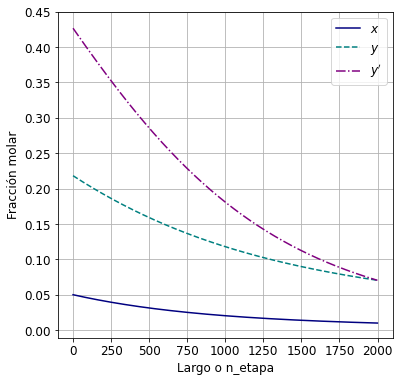

In [12]:
# Este código traza los resultados del problema de separación de membranas.

# Crea una figura con un ancho y alto de 6 pulgadas.
plt.figure(figsize = [6,6])

# Grafica los valores de x, etiquetados como $x$, en azul marino.
plt.plot(np.flip(x), label='$x$', color = 'navy')

# Grafica los valores de y, etiquetados como $y$, en verde azulado con una línea punteada.
plt.plot(np.flip(y), label = '$y$', color = 'teal', ls = '--')

# Grafica los valores de y', etiquetados como $y\'$, en morado con una línea punteada.
plt.plot(np.flip(yp_av_list), label = '$y\'$', color = 'purple', ls = '-.')

# Agrega etiquetas a los ejes x e y, con un tamaño de fuente de 12.
plt.xlabel('Largo o n_etapa', size = 12)
plt.ylabel('Fracción molar', size = 12)

# Establece el tamaño de fuente de las etiquetas de marcas a 12.
plt.tick_params(labelsize = 12)

# Agrega una cuadrícula a la trama.
plt.grid()

# Agrega una leyenda a la trama, con un tamaño de fuente de 12.
plt.legend(fontsize = 12)

# Guarda la trama como un archivo llamado `c22_solution.svg`.
# plt.savefig("c22_solution.svg", bbox_inches = 'tight')
ax = plt.gca()
ax.set_yticks(np.arange(0, 0.5, 0.05))

# Muestra la trama.
plt.show()


In [12]:
print(y)

[0.07044358 0.07044381 0.07047397 ... 0.21790104 0.21804035 0.21817975]


De esta forma, se recomienda utilizar la membrana Hyfon para recuperar el hidrógeno debido a que posee una mejor permeabilidad. Lo que requeriría una membrana de 3000 m2 y genera una corriente de permeado de 21.81% de hidrógeno y con una etapa de corte del 19.3%. En la siguiente etapa será necesario purificar esta corriente.

# P2)

In [71]:
# Fracción molar de hidrógeno en el residuo
x_out_2 = 0.0771

# Valor arbitrario del residuo
L_out_2 = 30739 # L/min
V_out = 0 # L/min

# Coeficiente de permeabilidad del gas más permeable (H2) en la membrana Hyflon
q_A2 = 9.3/1000 # L m /min*m^2*atm

# Permeabilidad del gas más permeable (H2) en la membrana Hyflon
z = 250/(10**6) #Espesor de la membrana, en metros
Q_A2 = q_A2/z # L/min*m^2*atm

# Selectividad de la membrana Hyflon
alpha_2 = 48

# Permeabilidad del gas menos permeable (CH4) en la membrana Hyflon
Q_B2 = Q_A2/alpha_2 # L/min*m^2*atm

# Razón de presiones
# Prueba con R muy bajaP_1 = 3.72
# Prueba con R muy alta, donde se exhibe la no linealidadP_1 = 30

P_1 = 3.5*10**5/101325 # atm
P_2 = 0.35*10**5/101325 # atm
R = P_2/P_1

In [72]:
# Calculamos y', la fracción molar del compuesto más permeable
# en la interface con el permeado en equilibrio con el retenido
yp = yp_mb_cc(x_out_2, alpha_2, R)
print(yp)
# En la salida del residuo se cumple que la fracción
# molar del soluto más permeable en el seno del 
# permeado, y, es igual a y'.

y = yp
x = x_out_2

# Cálculo de fluxes locales de A y B
J_A2 = Q_A2 * (P_1*x - P_2*y)
J_B2 = Q_B2 * (P_1*(1-x) - P_2 * (1-y))

0.5486814577850571


In [73]:
A = 731 # Conocemos el área superficial de la membrana
n = 4000
dA = A / n # Número de diferenciales de área

In [74]:
L, x, V, y, yp_av_list = membrane_countercurrent(L_out_2, x_out_2, yp, n, Q_A2, Q_B2, P_1, P_2)

In [75]:
# Etapa de corte
stage_cut_1 = V[-1]/L[-1]
print("La etapa de corte es = %.3f" % stage_cut_1)

La etapa de corte es = 0.199


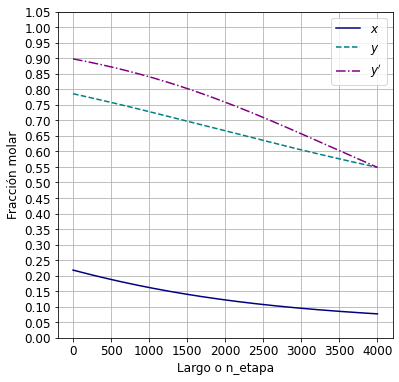

In [76]:
# Este código traza los resultados del problema de separación de membranas.

# Crea una figura con un ancho y alto de 6 pulgadas.
plt.figure(figsize = [6,6])

# Grafica los valores de x, etiquetados como $x$, en azul marino.
plt.plot(np.flip(x), label='$x$', color = 'navy')

# Grafica los valores de y, etiquetados como $y$, en verde azulado con una línea punteada.
plt.plot(np.flip(y), label = '$y$', color = 'teal', ls = '--')

# Grafica los valores de y', etiquetados como $y\'$, en morado con una línea punteada.
plt.plot(np.flip(yp_av_list), label = '$y\'$', color = 'purple', ls = '-.')

# Agrega etiquetas a los ejes x e y, con un tamaño de fuente de 12.
plt.xlabel('Largo o n_etapa', size = 12)
plt.ylabel('Fracción molar', size = 12)

# Establece el tamaño de fuente de las etiquetas de marcas a 12.
plt.tick_params(labelsize = 12)

# Agrega una cuadrícula a la trama.
plt.grid()

# Agrega una leyenda a la trama, con un tamaño de fuente de 12.
plt.legend(fontsize = 12)

# Guarda la trama como un archivo llamado `c22_solution.svg`.
# plt.savefig("c22_solution.svg", bbox_inches = 'tight')
ax = plt.gca()
ax.set_yticks(np.arange(0, 1.1, 0.05))

# Muestra la trama.
plt.show()


In [77]:
print(x, y)
print(L,V)


[0.0771     0.0771146  0.07712919 ... 0.21784796 0.2179125  0.21797706] [0.54868146 0.54868352 0.54874252 ... 0.78554216 0.78559579 0.78564942]
[30739.         30739.95149642 30740.90299284 ... 38361.07428781
 38364.71610673 38368.35928608] [0.00000000e+00 9.51496422e-01 1.90299284e+00 ... 7.62207429e+03
 7.62571611e+03 7.62935929e+03]


# P3)

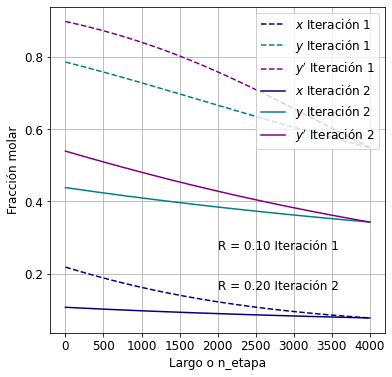

In [78]:
import matplotlib.pyplot as plt
import numpy as np

# Crear la figura
plt.figure(figsize=[6, 6])

for i in range(0, 2):
    R = 0.1 + i / 10
    P_1 = 3.5 * 10**5 / 101325  # atm
    P_2 = P_1 * R
    # Calculamos y', la fracción molar del compuesto más permeable
    yp = yp_mb_cc(x_out_2, alpha_2, R)
    y = yp
    x = x_out_2
    # Cálculo de fluxes locales de A y B
    J_A2 = Q_A2 * (P_1 * x - P_2 * y)
    J_B2 = Q_B2 * (P_1 * (1 - x) - P_2 * (1 - y))
    L, x, V, y, yp_av_list = membrane_countercurrent(L_out_2, x_out_2, yp, n, Q_A2, Q_B2, P_1, P_2)
    
    # Si es la primera iteración, usa línea discontinua, si es la segunda, usa línea sólida
    if i == 0:
        linestyle = '--'  # Línea discontinua para la primera iteración
    else:
        linestyle = '-'   # Línea sólida para la segunda iteración
    
    # Graficar los valores de x, y y yp_av_list en el mismo gráfico
    plt.plot(np.flip(x), label=f'$x$ Iteración {i+1}', color='navy', ls=linestyle)
    plt.plot(np.flip(y), label=f'$y$ Iteración {i+1}', color='teal', ls=linestyle)
    plt.plot(np.flip(yp_av_list), label=f"$y'$ Iteración {i+1}", color='purple', ls=linestyle)
    # Imprimir el valor de R en el gráfico
    plt.text(len(x)//2, max(x) + 0.05, f'R = {R:.2f} Iteración {i+1}', fontsize=12, color='black')

# Configuración del gráfico
plt.xlabel('Largo o n_etapa', size=12)
plt.ylabel('Fracción molar', size=12)
plt.tick_params(labelsize=12)
plt.grid()

# Agregar leyenda
plt.legend(fontsize=12)

# Mostrar la figura con todos los gráficos superpuestos
plt.show()

